In [3]:
import geopandas as gpd                 # spatial data
import pandas as pd                     # tabular data
import numpy as np                      # numerical ops
import matplotlib.pyplot as plt         # plots
from shapely import wkt                 # import used to convert strings into shapely Polygons

from libpysal.weights import Queen      # spatial weights
from esda.moran import Moran            # Moran’s I statistic
from esda.moran import Moran_Local      # Separate import to do Local Moran
from splot.esda import moran_scatterplot # plot Moran scatterplot
import statsmodels.api as sm

In [9]:
gdf = gpd.read_file("../Week_3/h3_elasticity_clusters.geojson")
# make hundreds of rows. Increase amount of data.
gdf = pd.concat([gdf] * 50, ignore_index=True)
print("Number of rows:", len(gdf)) 
print(gdf.columns)

Number of rows: 750
Index(['h3_origin', 'trips_sum', 'price_mean', 'treated', 'price_mean_new',
       'trips_simulated', 'trips_change_pct', 'elasticity_estimate',
       'local_moran_I', 'moran_cluster', 'geometry'],
      dtype='object')


In [11]:
gdf = gdf.dropna(subset=["price_mean","trips_sum", "moran_cluster"])

In [35]:
# convert numeric columns from object to float (numbers were stored as strings) 
numeric_cols = ["trips_sum", "price_mean", "price_mean_new", 
                "trips_simulated", "trips_change_pct"]
for col in numeric_cols:
    gdf[col] = pd.to_numeric(gdf[col], errors="coerce")

In [57]:
# creating X with numeric features only
X = pd.concat([
    gdf[["trips_sum"]],
    pd.get_dummies(gdf["moran_cluster"], prefix="moran", drop_first=True)
], axis=1)

# force conversion to numeric. We want to observe the effects of trips_sum, moran_cluster on price_mean. 
# price_mean is the dependent variable, moran_cluster and trips_sum are independent variables.
X = X.apply(pd.to_numeric, errors="coerce")
y = pd.to_numeric(gdf["price_mean"], errors="coerce")

# drop rows with nans
data = pd.concat([X, y], axis=1).dropna()
X = data.drop(columns=["price_mean"])
y = data["price_mean"]

# Add constant term for intercept in regression. Convert to numpy arrays to eliminate objects
X = sm.add_constant(X.values.astype(float))
y = y.values.astype(float)

# OLS
ols_model = sm.OLS(y, X).fit()
print(ols_model.summary())

# R-squared of 0.347 -> 34.7% of the variation in price_mean is explained by my predictors (trips_sum and moran_cluster) 
# F statistic -> overall model is statistically significant. 
# significance if p value is less than 0.05. 
# trips_sum is x1. for each extra trip, price decreases by about 0.0157. 
# high high moran cluster is x2. is significant -> prices in hot spot clusters are higher. 
# low low moran cluster is x3. is not significant -> clusters don't impact price. 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.347
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     131.9
Date:                Sat, 02 Aug 2025   Prob (F-statistic):           1.50e-68
Time:                        15:33:11   Log-Likelihood:                -1180.8
No. Observations:                 750   AIC:                             2370.
Df Residuals:                     746   BIC:                             2388.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         21.1529      0.179    118.163      0.0

In [59]:
# Extract and print coefficients and R-squared
print("Coefficients:", ols_model.params)
print("R-squared:", ols_model.rsquared)

# abt 34.7% of variation in price_mean is explained by trips and moran clusters. 

# 21.15 is baseline price for polygon w/ 0 trips. 
# each additional trip is associated w/ 1.57 cent decrease in price.
# being in high high cluster increases price by 0.36 compared to "non significant" clusters.
# being in low low cluster decreases price by 0.14. (but NOT statistically significant analysis) 

Coefficients: [ 2.11528590e+01 -1.57484428e-02  3.57310140e-01 -1.36268161e-01]
R-squared: 0.34658449883787346


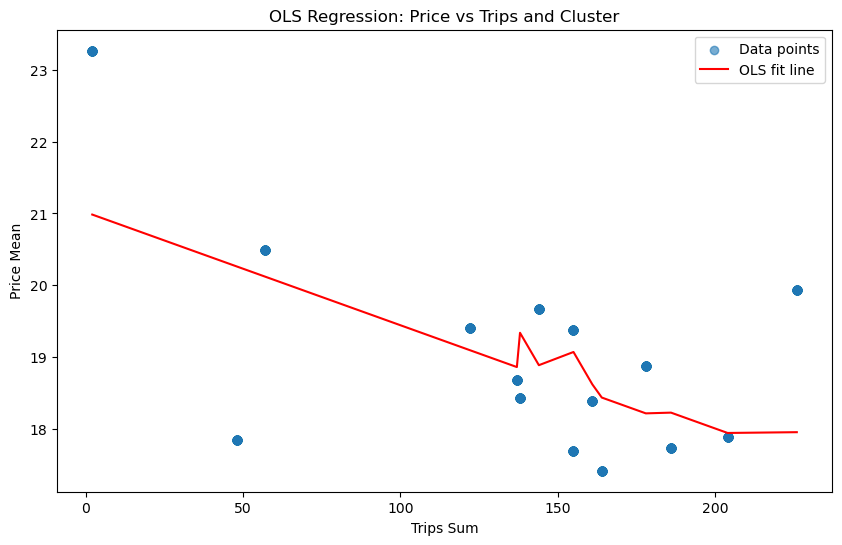

In [71]:
# Visualize relationship between trips_sum and price_mean
plt.figure(figsize=(10,6))
plt.scatter(gdf["trips_sum"], gdf["price_mean"], alpha=0.6, label="Data points")
# want x values (trips) to be in ascending order. not in original row order. 
sorted_idx = gdf["trips_sum"].argsort()
plt.plot(gdf["trips_sum"].iloc[sorted_idx],
         ols_model.predict(X)[sorted_idx],
         color="red", label="OLS fit line")
#plt.plot(gdf["price_mean"], ols_model.predict(X), color="red", label="OLS fit line")
plt.xlabel("Trips Sum")
plt.ylabel("Price Mean")
plt.title("OLS Regression: Price vs Trips and Cluster")
plt.legend()
plt.show()

In [75]:
w = Queen.from_dataframe(gdf)
w.transform = "r"

# Fit Spatial Lag Model
from spreg import ML_Lag

lag_model = ML_Lag(y, X, w=w)
print("Spatial Lag Coefficients:", lag_model.betas.flatten())

# Fit Spatial Error Model
from spreg import ML_Error

error_model = ML_Error(y, X, w=w)
print("Spatial Error Coefficients:", error_model.betas.flatten())


# Strong spatial autocorrelation. prices in one area are highly correlated w/ prices in other areas. rho = 0.95. lambda = 0.99
# high-high clusters increase price. 
# trips_sum negatively related to price. (competitive pricing) 

/var/folders/w3/f3zhp9t17_7cxs5hc0t1bznw0000gn/T/ipykernel_59869/3595304705.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(gdf)
/opt/anaconda3/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 8 disconnected components.
  W.__init__(self, neighbors, ids=ids, **kw)


Spatial Lag Coefficients: [ 1.26287642 -0.00295648  0.6259507  -0.07013536  0.94863509]
Spatial Error Coefficients: [20.12881991 -0.02384326  1.04551029  0.87104079  0.98678793]


/opt/anaconda3/lib/python3.12/site-packages/spreg/ml_error.py:184: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


In [ ]:
# Interpretation:
# - How do coefficients differ between OLS and spatial models?
# in spatial model, coefficient is much lower. 
# all models agree trips are negatively associated with price. 
# spatial model amplifies effect of high high clusters, cluster pricing increases when there's spacial dependence. 
# in OLS, low low clusters reduce price, but in spatial error, they slightly increase price. (hidding spatial factors?)

# - Which model has better statistical properties?
# Both models (ML_Lag and ML_Error) are better than OLS because they check if spatial dependence exists. 

# - What does spatial dependence imply about Uber pricing strategy?
# prices in a location are not independent but influenced by prices in other neighboring areas. Prices move together to reduce 
# price competition between neighboring locations. Prices in one hexagon can never be isolated. 